# Opening a Venezuelan Restaurant in New York City

Capstone Project - The Battle of Neighborhoods (Week 1)

By:
Alejandro Merino

## Description

Due to the economical, political and social issues Venezuela is currently facing; New York has seen an increased influx of Venezuelans during the last decade. This results in an increased demand for Venezuelan restaurants. The purpose of this project is to explore the best locations in New York City for Venezuelan Restaurants. Potentially helping future venezuelan restaurant owners experience great success and consistent profit. 

Because opening a restaurnt requires a tremendous amount of research and a deep look into a wide variety of variables; our main focus will be the location itself. We will answer one particular questions, and that would be Where should the future restaurant owner open its Venezuelan restaurant?

## Data Description

### Data Needed

To solve this question, we would need the following information
<ul>
<li>New York City Data containing the neighborhoods and boroughs
<li>Coordinates (Latitude and Longitude) of these neighborhoods. In order to plot the data into a map and obtain venue data
<li>Obtain venue data from Foursquare API related to restaurants in order to determine best locations for a Venezuelan Restaurant. 


# Data Preparation

## Building Dataframe

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#uncomment and install it, I've already installed 
#!conda install -c conda-forge geopy --yes
!pip install geocoder
from geopy.geocoders import Nominatim 
import geocoder

import requests 
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#uncomment and install it, I've already installed
#!conda install -c conda-forge folium=0.5.0 --yes 
!pip install folium
import folium

# import the library we use to open URLs
import urllib.request

from bs4 import BeautifulSoup

print('Libraries imported.')

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 98 kB 8.0 MB/s  eta 0:00:01
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |██████████████████

## Obtaining Data of New York Boroughs and Neighborhoods

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


### Load and explore the data

#### Lets load the data

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's define a new variable that includes the features key

In [4]:
neighborhoods_data = newyork_data['features']

neighborhoods_data[0]

#### Transform the data into a Pandas Dataframe

The next task is essentially transforming this data of nested Python dictionaries into a pandas dataframe. So let's start by creating an empty dataframe.

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [6]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude




Then let's loop through the data and fill the dataframe one row at a time.


In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.


In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

# Exploring ang Segmenting Neighborhoods

Defining Foursquare credentials

In [12]:
CLIENT_ID = 'UOHHHJZY2KYT2ZWOKQXNXLTHHEDY2Q4ZGMUSHNWZQ50YD2M5' # your Foursquare ID
CLIENT_SECRET = '1PER2YG4IEZLKLURRNJOFBEBJRK4W4Z5Q0OMZNM5RKUYZLMX' # your Foursquare Secret
ACCESS_TOKEN = 'EU00TTPD3JLRK4NXG1BPYTIFUPPKRZS1GHD2QN0IF3SLAZDQ' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UOHHHJZY2KYT2ZWOKQXNXLTHHEDY2Q4ZGMUSHNWZQ50YD2M5
CLIENT_SECRET:1PER2YG4IEZLKLURRNJOFBEBJRK4W4Z5Q0OMZNM5RKUYZLMX


Defining Functions we are going to later be using 

In [13]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=5000
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [14]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [15]:
ny_data.shape

(306, 4)

## Initial Data Analysis

In [16]:
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

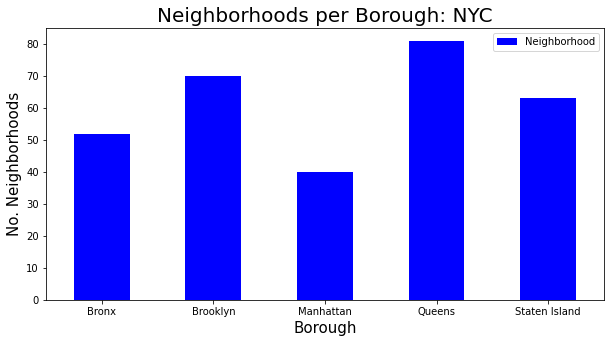

In [17]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Lets analyze it further and see how many Venezuelan restaurants there are in each neighborhood and bourough. 

In [18]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
venezuelan_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    venezuelan_restaurants=venues[venues['Category']=='Venezuelan Restaurant']   
    print('(',count,'/',len(ny_data),')','Venezuelan Restaurants in '+Neighborhood+', '+Borough+':'+str(len(venezuelan_restaurants)))
    print(row)
    for resturant_detail in venezuelan_restaurants.values.tolist():
        id, name , category=resturant_detail
        venezuelan_rest_ny = venezuelan_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Venezuelan Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Venezuelan Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Venezuelan Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Venezuelan Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Venezuelan Restaurants in Riverdale, Bronx:1
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Venezuelan Restaurants in Kingsbridge, Bronx:1
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Venezuelan Restaurants in Marble Hill, Manhattan:1
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Venezuelan Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Venezuelan Restaur

In [22]:
venezuelan_rest_ny.to_csv('venezuelan_rest_ny_tocsv1.csv')

In [23]:
venezuelan_ny = pd.read_csv('venezuelan_rest_ny_tocsv1.csv')
venezuelan_rest_ny

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,4e3e2ee3b61cb577be82354b,Patacon Pisao
1,Bronx,Kingsbridge,4e3e2ee3b61cb577be82354b,Patacon Pisao
2,Manhattan,Marble Hill,4e3e2ee3b61cb577be82354b,Patacon Pisao
3,Bronx,University Heights,4e3e2ee3b61cb577be82354b,Patacon Pisao
4,Bronx,Morris Heights,4e3e2ee3b61cb577be82354b,Patacon Pisao
5,Bronx,Fordham,4e3e2ee3b61cb577be82354b,Patacon Pisao
6,Bronx,Spuyten Duyvil,4e3e2ee3b61cb577be82354b,Patacon Pisao
7,Manhattan,Washington Heights,4e3e2ee3b61cb577be82354b,Patacon Pisao
8,Manhattan,Inwood,4e3e2ee3b61cb577be82354b,Patacon Pisao
9,Bronx,Mount Eden,4e3e2ee3b61cb577be82354b,Patacon Pisao


In [24]:
venezuelan_rest_ny.shape

(12, 4)

We got 12 Venezuelan Restaurants across New York City. 

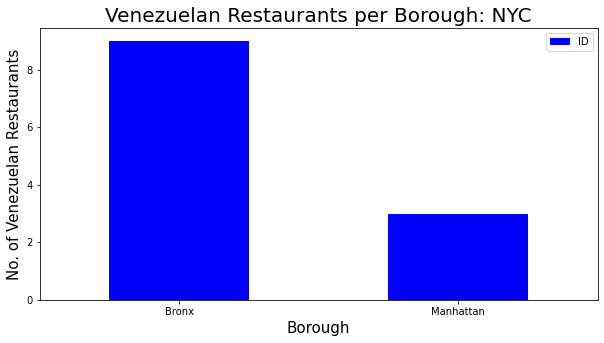

In [25]:
venezuelan_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Venezuelan Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Venezuelan Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

We can see that most Venezuelan restaurants are located in the Bronx area. 8 restaurants in Bronx, compared to only 2 located in the Manhattan area. 

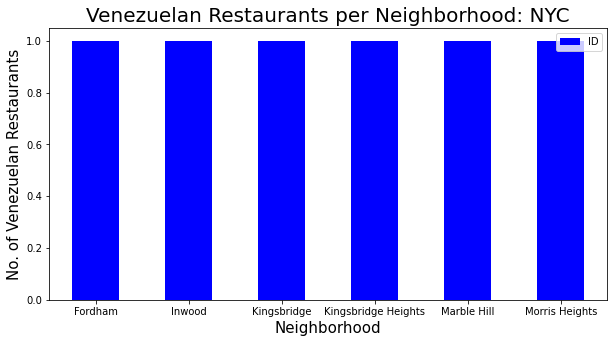

In [26]:
NOofNeigh = 6 # top number for graphing all the same past 6
venezuelan_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Venezuelan Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Venezuelan Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

The venezuelan restaurants are evenly spread throughout the bourougs

Lets analyze now the ranking for each of the Venezuelan restaurants

In [27]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
venezuelan_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in venezuelan_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(venezuelan_rest_ny),')','processed')
    venezuelan_rest_stats_ny = venezuelan_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
venezuelan_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '6102f6ce70c6c074da569db5'}, 'response': {'venue': {'id': '4e3e2ee3b61cb577be82354b', 'name': 'Patacon Pisao', 'contact': {'phone': '9179719828', 'formattedPhone': '(917) 971-9828', 'twitter': 'pataconpisaonyc'}, 'location': {'address': '431 W 202nd St', 'lat': 40.86111992683795, 'lng': -73.92079322906424, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86111992683795, 'lng': -73.92079322906424}], 'postalCode': '10034', 'cc': 'US', 'neighborhood': 'Inwood', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['431 W 202nd St', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patacon-pisao/4e3e2ee3b61cb577be82354b', 'categories': [{'id': '56aa371be4b08b9a8d573558', 'name': 'Venezuelan Restaurant', 'pluralName': 'Venezuelan Restaurants', 'shortName': 'Venezuelan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/argentinian_', 'suffix': '.png'}, 'primary': True}, {'id': '

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
7,Manhattan,Washington Heights,4e3e2ee3b61cb577be82354b,Patacon Pisao,36,8.3,8
8,Manhattan,Inwood,4e3e2ee3b61cb577be82354b,Patacon Pisao,36,8.3,8
9,Bronx,Mount Eden,4e3e2ee3b61cb577be82354b,Patacon Pisao,36,8.3,8
10,Bronx,Mount Hope,4e3e2ee3b61cb577be82354b,Patacon Pisao,36,8.3,8
11,Bronx,Kingsbridge Heights,4e3e2ee3b61cb577be82354b,Patacon Pisao,36,8.3,8


In [28]:
venezuelan_rest_stats_ny.to_csv('venezuelan_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [29]:
venezuelan_rest_stats_ny.shape

(12, 7)

In [30]:
venezuelan_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       12 non-null     object 
 1   Neighborhood  12 non-null     object 
 2   ID            12 non-null     object 
 3   Name          12 non-null     object 
 4   Likes         12 non-null     object 
 5   Rating        12 non-null     float64
 6   Tips          12 non-null     object 
dtypes: float64(1), object(6)
memory usage: 800.0+ bytes


In [31]:
venezuelan_rest_stats_ny['Likes'] = venezuelan_rest_stats_ny['Likes'].astype('float64')
venezuelan_rest_stats_ny['Tips'] = venezuelan_rest_stats_ny['Tips'].astype('float64')
venezuelan_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       12 non-null     object 
 1   Neighborhood  12 non-null     object 
 2   ID            12 non-null     object 
 3   Name          12 non-null     object 
 4   Likes         12 non-null     float64
 5   Rating        12 non-null     float64
 6   Tips          12 non-null     float64
dtypes: float64(3), object(4)
memory usage: 800.0+ bytes


In [34]:
venezuelan_rest_stats_ny.describe()

,Likes,Rating,Tips
count,12.0,1.200000e+01,12.0
mean,36.0,8.300000e+00,8.0
std,0.0,1.855344e-15,0.0
min,36.0,8.300000e+00,8.0
25%,36.0,8.300000e+00,8.0
50%,36.0,8.300000e+00,8.0
75%,36.0,8.300000e+00,8.0
max,36.0,8.300000e+00,8.0


## Lets dig deeper into the neighborhood with the highest average rating of restaurants

In [35]:
ny_neighborhood_stats=venezuelan_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Fordham,8.3
1,Inwood,8.3
2,Kingsbridge,8.3
3,Kingsbridge Heights,8.3
4,Marble Hill,8.3
5,Morris Heights,8.3
6,Mount Eden,8.3
7,Mount Hope,8.3
8,Riverdale,8.3
9,Spuyten Duyvil,8.3


These are the top neighborhoods with the highest ratings on venezuelan restaurants

In [36]:
ny_borough_stats=venezuelan_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.3
0,Bronx,8.3


Subsenquently, these are the bouroughs that have the top ratings for Venezuelan Restaurants

### If we visualize the results, this is what we get

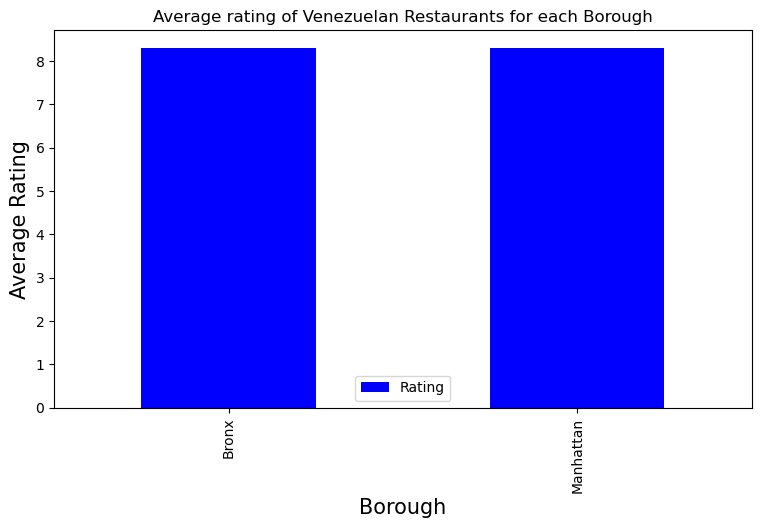

In [37]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Venezuelan Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
venezuelan_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [38]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Fordham,8.3
1,Inwood,8.3
2,Kingsbridge,8.3
3,Kingsbridge Heights,8.3
4,Marble Hill,8.3
5,Morris Heights,8.3
6,Mount Eden,8.3
7,Mount Hope,8.3
8,Riverdale,8.3
9,Spuyten Duyvil,8.3


In [39]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Fordham,40.860997,-73.896427,8.3
1,Manhattan,Inwood,40.867684,-73.921210,8.3
2,Bronx,Kingsbridge,40.881687,-73.902818,8.3
3,Bronx,Kingsbridge Heights,40.870392,-73.901523,8.3
4,Manhattan,Marble Hill,40.876551,-73.910660,8.3
5,Bronx,Morris Heights,40.847898,-73.919672,8.3
6,Bronx,Mount Eden,40.843826,-73.916556,8.3
7,Bronx,Mount Hope,40.848842,-73.908299,8.3
8,Bronx,Riverdale,40.890834,-73.912585,8.3
9,Bronx,Spuyten Duyvil,40.881395,-73.917190,8.3


## Lets go ahead and create a map to visualize the neighborhoods

In [40]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [41]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

# Conclusion

In conclusion, we can determine that Bronx is the best area in New York in order to open a Venezuelan Restaurant. It is a borough that is familiar with the food and overall supports this cuisine by providing good enough ratings. 

Manhattan in the other hand is a market with untapped potential. Only one Venezuelan Restaurant in the area. It could potentially mean that there is still plenty of room to obtain first come advantage. In other words, given that there are not that many Venezuelan Restuants; people who want to try this cuisine would go to your restaurant. If they like the food, then we will come back as there are not any options around. 